# Default Kaggle kernel line:  Show the database

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../"),'\n')
print(os.listdir("../input"), '\n')
print(os.listdir("../input/train_simplified"), '\n')
# Any results you write to the current directory are saved as output.

['.ipynb_checkpoints', '2018-10-08', 'combine_validation_csv.ipynb', 'data', 'File_creator.ipynb', 'input', 'kernel.ipynb', 'labs_lecture13', 'output', 'pretrained', 'sample_submission.csv', 'test_raw.csv', 'train_raw', 'train_raw.zip', 'train_simplified.zip'] 

['..data', '.ipynb_checkpoints', 'Fork_linc_ResNet.ipynb', 'kernel_1621.ipynb', 'linc_resnet (2)-Copy1.ipynb', 'linc_resnet (2)-Copy2.ipynb', 'linc_resnet (2).ipynb', 'linc_ResNet.ipynb', 'load files.ipynb', 'test_simplified.csv', 'train_simplified', 'Untitled.ipynb', 'validation_aye.csv'] 

['airplane.csv', 'alarm clock.csv', 'ambulance.csv', 'angel.csv', 'animal migration.csv', 'ant.csv', 'anvil.csv', 'apple.csv', 'arm.csv', 'asparagus.csv', 'axe.csv', 'backpack.csv', 'banana.csv', 'bandage.csv', 'barn.csv', 'baseball bat.csv', 'baseball.csv', 'basket.csv', 'basketball.csv', 'bat.csv', 'bathtub.csv', 'beach.csv', 'bear.csv', 'beard.csv', 'bed.csv', 'bee.csv', 'belt.csv', 'bench.csv', 'bicycle.csv', 'binoculars.csv', 'bird.csv

# 1.1 Kaggle - Quickdraw: ResNet
###        Import the necessary libraries

In [2]:
# std libs
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.cm
import matplotlib.pyplot as plt
%matplotlib inline
import time
import random
import math
from tqdm import tqdm_notebook
from glob import glob
from timeit import default_timer as timer
import gc

#Pytorch libs
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import *

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parallel.data_parallel import data_parallel



def time_to_str(t, mode='min'):
    if mode=='min':
        t  = int(t)/60
        hr = t//60
        min = t%60
        return '%2d hr %02d min'%(hr,min)

    elif mode=='sec':
        t   = int(t)
        min = t//60
        sec = t%60
        return '%2d min %02d sec'%(min,sec)



# 1.2 Setting up gpu
   * Optimising gpu

In [3]:
SEED = 35202
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
print('Set random seed')
print('\tSEED = %d'%SEED)

torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
torch.backends.cudnn.enabled   = True
print ('\tset cuda environment')
print ('\t\ttorch.__version__              =', torch.__version__)
print ('\t\ttorch.version.cuda             =', torch.version.cuda)
print ('\t\ttorch.backends.cudnn.versiaon() =', torch.backends.cudnn.version())
try:
    print ('\t\tos[\'CUDA_VISIBLE_DEVICES\']     =',os.environ['CUDA_VISIBLE_DEVICES'])
    NUM_CUDA_DEVICES = len(os.environ['CUDA_VISIBLE_DEVICES'].split(','))
except Exception:
    print ('\t\tos[\'CUDA_VISIBLE_DEVICES\']     =','None')
    NUM_CUDA_DEVICES = 1

print ('\t\ttorch.cuda.device_count()      =', torch.cuda.device_count())
    #print ('\t\ttorch.cuda.current_device()    =', torch.cuda.current_device())

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('\tDevice used: ',device)
print('')

Set random seed
	SEED = 35202
	set cuda environment
		torch.__version__              = 0.4.1
		torch.version.cuda             = 9.0
		torch.backends.cudnn.versiaon() = 7005
		os['CUDA_VISIBLE_DEVICES']     = None
		torch.cuda.device_count()      = 1
	Device used:  cuda



# 1.3 Data Processing
* Extracting data; spliting them into train and eval (train_simplified.csv will be used)
* Image Generation from Stroke
* Raw trained data split into two files(Train and Eval) given by indices.
In this way we know which are being referenced, instead of loading them and dividing them.

## 1.3.1 Visualise the data
### control the *'data_len'* to display the number of class output

In [4]:
def visualise_data(data_len = 6):
    file_names = glob('../input/train_simplified/*.csv')
    #column_names = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
    if data_len >= len(file_names) or data_len <= 0:
        data_len = 6
    
    #A list to sample some data
    drawlist = []
    
    for f in file_names[0:data_len]:
        data_sample = pd.read_csv(f, nrows = 10)
        #apple = data_sample
        #keyid = apple.key_id[:2]
        #print(keyid)
        #drawid=apple.loc[apple['key_id'].isin(keyid)].index.values
        #print('hit this',drawid)
        data_sample = data_sample[data_sample.recognized==True].head(2)
        drawlist.append(data_sample)
        column_names = list(data_sample)
        #drawing_id = df.loc[df['key_id'].isin(key_id)].index.values
        visualise_df = pd.DataFrame(np.concatenate(drawlist), columns=column_names)
    
    return visualise_df

see_data = visualise_data()
see_data



,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, ...",5152802093400064,True,2017-03-08 21:12:07.266040,airplane
1,US,"[[[90, 88, 95, 104, 112, 122], [65, 31, 12, 0,...",6577010312740864,True,2017-03-23 02:08:35.229980,airplane
2,US,"[[[111, 148, 161, 175, 199, 218, 231, 236, 234...",5159910851477504,True,2017-03-21 13:02:16.246170,alarm clock
3,US,"[[[154, 144, 129, 86, 66, 45, 45, 50, 76, 111,...",4608088873107456,True,2017-03-01 21:42:04.745090,alarm clock
4,US,"[[[13, 10, 12, 20, 39, 67, 170, 196, 213, 220,...",5404586804248576,True,2017-01-24 12:58:28.487110,ambulance
5,US,"[[[9, 8, 0, 1, 5, 117, 166, 206, 216, 221, 249...",5731655589298176,True,2017-03-28 15:53:40.978600,ambulance
6,US,"[[[128, 116, 99, 87, 77, 75, 80, 90, 114, 130,...",6665588124418048,True,2017-03-03 20:39:08.851890,angel
7,JP,"[[[98, 74, 52, 46, 44, 52, 63, 82, 116, 137, 1...",5275268287561728,True,2017-03-05 05:52:48.496610,angel
8,HR,"[[[19, 52], [44, 50]], [[0, 0, 5], [56, 65, 69...",4975017072787456,True,2017-03-22 11:34:53.899460,animal migration
9,US,"[[[0, 3, 12, 23, 40, 47, 53, 53, 49, 68, 88, 1...",4993426342805504,True,2017-03-25 02:43:14.994860,animal migration


## 1.3.2 Drawing to Image
This function will take in data sample one bye one and use the coordinate points to draw out a black and white  image.
1. This function takes in drawing points as 'drawing' and dimensions as 'H' and 'W'. Register each stroke base on the time T. And plot it out with cv2.line after the image matrix is 'dotted' with the drawing points
2. Activate your data augmentation here, it will automatically rotate the image as and when it likes...

In [5]:
def rotateImage(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result
def draw_to_image(drawing, H, W):
    
    data_augment = False
    points = []
    time = []
    #Save all the data from drawing into an array
    for t,(x,y) in enumerate(drawing):
        points.append(np.array((x,y),np.float32).T)
        time.append(np.full(len(x),t))
    
        
    points = np.concatenate(points).astype(np.float32)
    time = np.concatenate(time).astype(np.int32)
    #print('This is how the points look like \n', points[:3])
    #print('This is how time be like:\n', time[:3])
    #Create the skeleton of an image......................................
    image  = np.full((H,W,3),0,np.uint8)
    x_max = points[:,0].max()
    x_min = points[:,0].min()
    y_max = points[:,1].max()
    y_min = points[:,1].min()
    w = x_max-x_min
    h = y_max-y_min
    s = max(w,h)
    
    #Normalise the image
    norm_point = (points - [x_min,y_min]) / s  #Remove the empty space around it and shrink it to <=1
    norm_point = (norm_point -[w/s*0.5, h/s*0.5]) * max(W,H)*0.85  #Shift the centre of image to become the origin point, then resize it by scaling
    norm_point = np.floor(norm_point + [W/2, H/2]).astype(np.int32)  #Shift the smallest point bottom left of image to become the origin point, and also to stretch the image
    #..................................................................
    
    #It basically creates a dot then use cv2.line to draw it... 
    T = time.max()+1
    for t in range (T):
        p = norm_point[time==t] #taking one set of [x,y]  which is stack horizontally.
        x,y = p.T
        image[y,x] = 255
        N = len(p)
        for i in range(N-1):
            x0,y0 = p[i]
            x1,y1 = p[i+1]
            cv2.line(image,(x0,y0),(x1,y1),(255,255,255),1,cv2.LINE_AA) #Subjected to tunning for temporal
    if data_augment:
        angle_set = [0, 30, 0, 60, 0, 90, 0, 120, 150, 0 , 180, 0, 210, 0, 240, 0, 270, 0, 300, 0, 330, 360]
        angle  = np.random.choice(angle_set,1)
        image=rotateImage(image,angle)
    return image

  

### 1.3.2.1 Visualise the image

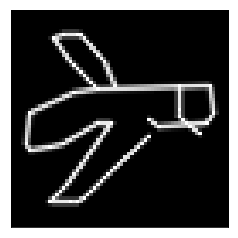

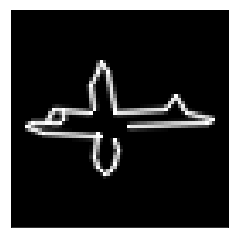

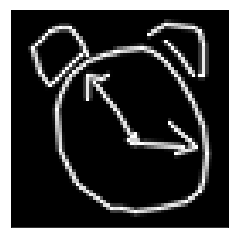

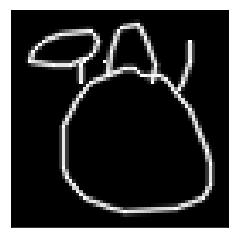

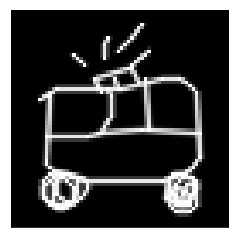

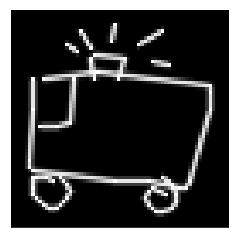

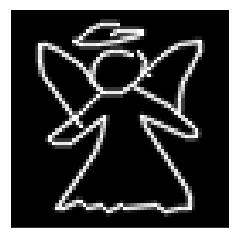

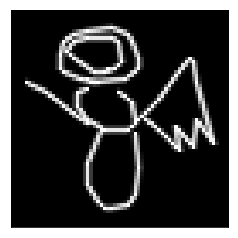

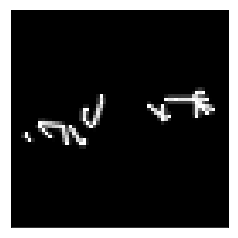

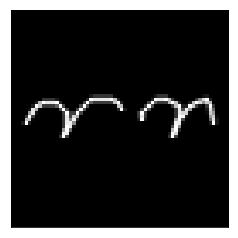

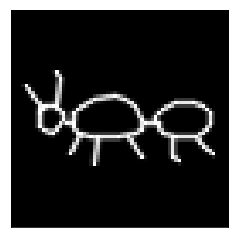

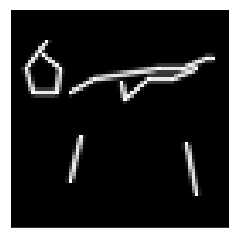

In [6]:
visualise_rawdata = (see_data['drawing'])
visualise_img=[]
for drawing in visualise_rawdata:
    drawing =eval(drawing)
    img = draw_to_image(drawing,64,64)
    
    visualise_img.append(img)
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

## 1.3.3 Create a class for data loading in pytorch later
[More details can be found here*](https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel)
In this section it is a function that is called in QuickdrawData for data creation.

In [7]:
def create_draw_data(drawing, label, index, key_id, dim = 64):
    cache = {'drawing': drawing.copy(), 'label' : label, 'index' : index, 'key_id' : key_id}
    #num = random.randint(0,9) #data augmenting
    #if (num in [5,9]):
    #    dim = 32
    #elif (num in [4,8]):
    #    dim = 128
    #elif (num in [1]):
    #    dim = 256
    #else:
    #    dim = 64
    image = draw_to_image(drawing, dim, dim)
    return image, label, cache


### 1.3.3.1 Dataset class
This will be use for the pytorch dataloader

In [8]:
TRAIN_DF = []
VALID_DF = []
TEST_DF = []
class_name = (x[:-4] for x in(os.listdir('../input/train_simplified/')))
class_name = sorted(list(class_name))

class QuickdrawData(Dataset):

    def __init__(self, mode, split='<NIL>', augment = create_draw_data, complexity = 'simplified'):
        super(QuickdrawData, self).__init__()
        assert complexity in ['simplified', 'raw']
        start = timer()

        self.split      = split
        self.augment    = augment
        self.mode       = mode
        self.complexity = complexity

        self.df  = []
        self.id  = []
        global TRAIN_DF,TEST_DF,VALID_DF
        if mode=='train':
            
            # countrycode, drawing, key_id, recognized, timestamp, word

            if (TRAIN_DF == []) and (split!= 'test_data'):
                for l,name in enumerate(class_name):
                    print('\r\t Now loading df   :  %3d/%3d   %24s   Time taken:%s'%(l,len(class_name),name,time_to_str((timer() - start))),end='',flush=True)
                    
                    
                    #Train data
                    df = pd.read_csv('../input/train_%s/%s.csv'%(complexity,name))[50000:95000]
                    df = df[df.recognized==True][:30100]
                    TRAIN_DF.append(df[:-100])
                    #print(len(df[:30000]))
                    VALID_DF.append(df[-100:])        
                            
                    del df
                                      
                    gc.collect()
                    
                print('')
            self.df = TRAIN_DF
            if (split == 'valid_data'):
                self.df = VALID_DF

            if (TEST_DF == []) and (split == 'test_data'):
                for l,name in enumerate(class_name):
                    print('\r\t Now loading test_df   :  %3d/%3d   %24s   Time taken:%s'%(l,len(class_name),name,time_to_str((timer() - start))),end='',flush=True)

                    #Train data
                    df = pd.read_csv('../input/train_%s/%s.csv'%(complexity,name))[:70000]
                    df = df[df.recognized==True][:40000]
                    df = df[30000:]
                    TEST_DF.append(df)                         

                    del df
                    gc.collect()
                self.df = TEST_DF

            
            
            
            for l,name in enumerate(class_name):
                print('\r\t load %s:  %3d/%3d   %24s   Time taken:%s'%(split,l,len(class_name),name,time_to_str((timer() - start))),end='',flush=True)
                if (split=='train_data'):
                    df = TRAIN_DF[l]
                elif (split=='valid_data'):
                    df = VALID_DF[l]
                elif (split=='test_data'):
                    df = TEST_DF[l]
                else:
                    raise Exception('Bug in dataset class')
                    
                key_id = df['key_id'].values.astype(np.int64) #np.load('../data/split/%s/%s.npy'%(split,name))
                label = np.full(len(key_id),l,np.int64)
                drawing_id = df.loc[df['key_id'].isin(key_id)].index.values
                self.id.append(
                    np.vstack([label, drawing_id, key_id]).T
                )
                del key_id,label,drawing_id,df
            self.id = np.concatenate(self.id)
            print('')

        if mode=='test':
            #global TEST_DF
            # key_id, countrycode, drawing

            if TEST_DF == []:
#                 TEST_DF = pd.read_csv(DATA_DIR + '/csv/test_%s.csv'%(complexity))
                TEST_DF = pd.read_csv('../input/test_%s.csv'%(complexity))
                
                self.id = np.arange(0,len(TEST_DF))

            self.df = TEST_DF

        print('')

    def __str__(self):
        N = len(self.id)
        string = ''\
        + '\tsplit        = %s\n'%self.split \
        + '\tmode         = %s\n'%self.mode \
        + '\tcomplexity   = %s\n'%self.complexity \
        + '\tlen(self.id) = %d\n'%N \
        + '\n'
        return string


    def __getitem__(self, index):


        if self.mode=='train':
            label, drawing_id, key_id = self.id[index]
            drawing = self.df[label]['drawing'][drawing_id]
            drawing = eval(drawing)

        if self.mode=='test':
            label=None
            drawing = self.df['drawing'][index]
            drawing = eval(drawing)
            key_id = self.df['key_id'][index]         

        return self.augment(drawing, label, index, key_id)

    def __len__(self):
        return len(self.id)


## 1.4 Downloading of pretrained resnet34 model

In [9]:
import urllib.request

pretrained_dir = '../pretrained/'
os.makedirs(pretrained_dir, exist_ok=True)

url = 'https://download.pytorch.org/models/resnet34-333f7ec4.pth'
filename = '../pretrained/resnet34-333f7ec4.pth'

# Download the file from `url` and save it locally under `file_name`:
with urllib.request.urlopen(url) as response, open(filename, 'wb') as out_file:
    data = response.read() # a `bytes` object
    out_file.write(data)

print('Downloaded ',os.listdir(pretrained_dir))

Downloaded  ['resnet34-333f7ec4.pth']


## 1.5 Make ResNet class
There is a given resnet model which can be found [here](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py).
### 1.5.1 Reference ResNet model

In [10]:
BatchNorm2d = nn.BatchNorm2d

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out



class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1   = BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

### 1.5.2 ResNet model for this net
This model will utilised the pretrained network for initialising, and it will use some blocks with reference to the 'Reference ResNet Model' above.

In [11]:
###########################################################################################3

class Net(nn.Module):

    def load_pretrain(self, pretrain_file):
        #raise NotImplementedError
        #self.resnet.load_state_dict(torch.load(pretrain_file, map_location=lambda storage, loc: storage))

        pretrain_state_dict = torch.load(pretrain_file)
        print("pretrain_state_dict.keys(): ", pretrain_state_dict.keys())
        state_dict = self.state_dict()
        print("state_dict.keys(): ", state_dict.keys())
        keys = list(state_dict.keys())
        for key in keys:
            if any(s in key for s in []):
                continue
            if "num_batches_tracked" in key:
                continue
            # if key.startswith('conv1.0'):
            #     state_dict[key] = pretrain_state_dict[key.replace('conv1.0','conv1')]
            # if key.startswith('conv1.1'):
            #     state_dict[key] = pretrain_state_dict[key.replace('conv1.1','bn1')]

            # if 'resnet.conv1.' in key:
            #     state_dict[key] = pretrain_state_dict[key.replace('resnet.conv1.','conv1.')]
            # if 'resnet.bn1.' in key:
            #     state_dict[key] = pretrain_state_dict[key.replace('resnet.bn1.','bn1.')]
            if 'encoder1.0.' in key:
                state_dict[key] = pretrain_state_dict[key.replace('encoder1.0.','conv1.')]
                print(key)
            if 'encoder1.1.' in key:
                state_dict[key] = pretrain_state_dict[key.replace('encoder1.1.','bn1.')]
                print(key)

            if any(s in key for s in []):
                continue
            if 'resnet.layer0.' in key:
                state_dict[key] = pretrain_state_dict[key.replace('resnet.layer0.','layer0.')]
                print(key)
            if 'resnet.layer1.' in key:
                print('key1: ',key)
#                 print('pretrain_state_dict: ',pretrain_state_dict)
                state_dict[key] = pretrain_state_dict[key.replace('resnet.layer1.','layer1.')]
                print('key2: ',key)
            if 'resnet.layer2.' in key:
                state_dict[key] = pretrain_state_dict[key.replace('resnet.layer2.','layer2.')]
                print(key)
            if 'resnet.layer3.' in key:
                state_dict[key] = pretrain_state_dict[key.replace('resnet.layer3.','layer3.')]
                print(key)
            if 'resnet.layer4.' in key:
                 state_dict[key] = pretrain_state_dict[key.replace('resnet.layer4.','layer4.')]
                 print(key)

        self.load_state_dict(state_dict)
        print('')


    def __init__(self, num_class=340):
        super(Net,self).__init__()
        self.resnet  = ResNet(BasicBlock, [3, 4, 6, 3],num_classes=1)

        # self.conv1 = nn.Sequential(
        #     self.resnet.conv1,
        #     self.resnet.bn1,
        #     self.resnet.relu,
        #     #self.resnet.maxpool,
        # )
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False),
            BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.encoder2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            self.resnet.layer1,
        )
        self.encoder3 = self.resnet.layer2
        self.encoder4 = self.resnet.layer3
        self.encoder5 = self.resnet.layer4
        self.logit = nn.Linear(512, num_class)



    def forward(self, x):
        batch_size,C,H,W = x.shape
        mean=[0.485, 0.456, 0.406] #rgb
        std =[0.229, 0.224, 0.225]
        x = torch.cat([
            (x[:,[0]]-mean[0])/std[0],
            (x[:,[1]]-mean[1])/std[1],
            (x[:,[2]]-mean[2])/std[2],
        ],1)

        x = self.encoder1(x) #; print('e1',x.size())
        x = self.encoder2(x) #; print('e2',x.size())
        x = self.encoder3(x) #; print('e3',x.size())
        x = self.encoder4(x) #; print('e4',x.size())
        x = self.encoder5(x) #; print('e5',x.size())

        x = F.adaptive_avg_pool2d(x, output_size=1).view(batch_size,-1)
        x = F.dropout(x, p=0.50, training=self.training)
        logit = self.logit(x)

        return logit


    def set_mode(self, mode, is_freeze_bn=False ):
        self.mode = mode
        if mode in ['eval', 'valid', 'test']:
            self.eval()
        elif mode in ['train']:
            self.train()
            if is_freeze_bn==True: ##freeze
                for m in self.modules():
                    if isinstance(m, BatchNorm2d):
                        m.eval()
                        m.weight.requires_grad = False
                        m.bias.requires_grad   = False


In [12]:
net = Net()
print('\n*****************************************************************************\n')
print(net)


*****************************************************************************

Net(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1)

)


## 1.6 Miscellaneous Functions
This can be considered as the utils package

In [13]:
def softmax_cross_entropy_criterion(logit, truth, is_average=True):
    loss = F.cross_entropy(logit, truth, reduce=is_average)
    return loss


def metric(logit, truth, is_average=True):
    """
    -prob: Gives a vertical tensor of probability
    -value, top: gives the probability and the top indices
    -correct: compare against the ground-truth labels to check if the top 3 categorizing is correct
    -correct(under if statement): average out the batch correct prediction
    *-avg_prob: comes from the prob but averaged; this is assumed to be sorted according to class label
            It is also not compared with the truth
    """
    with torch.no_grad():
        prob = F.softmax(logit, 1) #input (m,Num_Class_label); output (m, Num_Class_label)
        value, top = prob.topk(3, dim=1, largest=True, sorted=True)
        correct = top.eq(truth.view(-1, 1).expand_as(top))

        if is_average==True:
            # top-3 accuracy
            prob_avg = prob.float().sum(0, keepdim=False)
            correct = correct.float().sum(0, keepdim=False)
            correct = correct/len(truth)

            top = [correct[0], correct[0]+correct[1], correct[0]+correct[1]+correct[2]]
            precision = correct[0]/1 + correct[1]/2 + correct[2]/3
            return precision, top, prob_avg

        else:
            return correct



def null_collate(batch):
    batch_size = len(batch)
    cache = []
    input = []
    truth = []
    for b in range(batch_size):
        input.append(batch[b][0])
        truth.append(batch[b][1])
        cache.append(batch[b][2])
        del b

    input = np.array(input).transpose(0,3,1,2)
    input = torch.from_numpy(input).float()

    if truth[0] is not None:
        truth = np.array(truth)
        truth = torch.from_numpy(truth).long()

    return input, truth, cache

class NullScheduler():
    def __init__(self, lr=0.01 ):
        super(NullScheduler, self).__init__()
        self.lr    = lr
        self.cycle = 0

    def __call__(self, time):
        return self.lr

    def __str__(self):
        string = 'NullScheduler\n' \
                + 'lr=%0.5f '%(self.lr)
        return string
# https://github.com/pytorch/examples/blob/master/imagenet/main.py ###############
def adjust_learning_rate(optimizer, lr, iteration):
    lr = 0.2 * lr/(0.01+np.sqrt(iteration/8000))
    if (lr<0.0001):
        lr = 0.0001
    lr = 0.005        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def get_learning_rate(optimizer):
    lr=[]
    for param_group in optimizer.param_groups:
        lr +=[ param_group['lr'] ]

    assert(len(lr)==1) #we support only one param_group
    lr = lr[0]

    return lr


# 2 Main Script
## 2.1 Evaluation model and output

In [14]:
def do_valid( net, valid_generator, criterion ):

    valid_num  = 0
    probs    = []
    valid_labels   = []
    losses   = []
    corrects = []
    truths = []   
    
    for input, truth, cache  in valid_generator:
        
        input = input.to(device)
        truth = truth.to(device)
        
        with torch.no_grad():
            logit   = net(input)
            prob    = F.softmax(logit,1)

            loss    = criterion(logit, truth, False)
            correct = metric(logit, truth, False)
        
        valid_num += len(input)
        probs.append(prob.data.cpu().numpy())
        losses.append(loss.data.cpu().numpy())
        corrects.append(correct.data.cpu().numpy())
        truths.append(truth.data.cpu().numpy())
    
    
    
    
    assert(valid_num == len(valid_generator.sampler))
    #------------------------------------------------------
    
    prob    = np.concatenate(probs)
    correct = np.concatenate(corrects)
    truth   = np.concatenate(truths).astype(np.int32).reshape(-1,1)
    loss    = np.concatenate(losses)


    #---
    #top = np.argsort(-predict,1)[:,:3]

    loss    = loss.mean()
    correct = correct.mean(0)

    top = [correct[0], correct[0]+correct[1], correct[0]+correct[1]+correct[2]]
    precision = correct[0]/1 + correct[1]/2 + correct[2]/3

    #----
    valid_loss = np.array([
        loss, top[0], top[2], precision
    ])

    return valid_loss


## 2.2 Training Model

In [15]:
def run_train():
    """""
    This function will utilise the class and functions created above to produce image data and feed
    into the gpu for direct trianing by the neural network.
    
    --------------dataset-------------------
    In the creation of this, we will invoke
    ->class RandomSampler(Sampler): Samples elements randomly, without replacement.
        It can be thought of the order of visiting the image from the training set.
    ->nullcollate(): This function will take each batch of data and break them up into 'input, label(truth), cache'

   
    
    
    """
     #-----------------Setting up -----------------------------
    checkpoint_dir    = '../output/checkpoint'
    saved_dir         = '../output/saved'
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(saved_dir, exist_ok=True)
    pretrain_file_dir = '../pretrained/resnet34-333f7ec4.pth'
    load_model_dir    = '../output/checkpoint/Mi00019921_model.pth'
    if pretrain_file_dir is not None:
        print('\tpetrained_file_dir = %s\n'%pretrain_file_dir)
    
    schduler = NullScheduler(lr=0.001)
    criterion = softmax_cross_entropy_criterion
    train_loss = np.zeros(6,np.float32)
    valid_loss = np.zeros(6,np.float32)
    batch_loss = np.zeros(6, np.float32)
    #------------------PARAMETERS-------------------------------
    
    params = {'epochs': 3,
             'max_epoch': 100,
             'batch_size': 512
             }
    batch_size = params['batch_size']
   #---------------Dataset-------------------------------------
    
    train_dataset = QuickdrawData('train', 'train_data', create_draw_data)
    train_generator_params = {'sampler': RandomSampler(train_dataset),
                              'batch_size': params['batch_size'],
                              'drop_last': True,
                              'num_workers': 0,
                              'pin_memory': True,
                              'collate_fn': null_collate}
    train_generator = DataLoader(train_dataset, **train_generator_params)
    
    valid_dataset = QuickdrawData('train','valid_data',create_draw_data)
    valid_generator_params = {'sampler': RandomSampler(valid_dataset),
                              'batch_size': params['batch_size'],
                              'drop_last': False,
                              'num_workers': 0,
                              'pin_memory': True,
                              'collate_fn': null_collate}
    valid_generator = DataLoader(valid_dataset, **valid_generator_params)
        
    assert(len(train_dataset)>=params['batch_size'] )
    print('batch_size = %d\n'%(params['batch_size']))
    print('train_dataset : \n%s\n'%(train_dataset))
    print('valid_dataset : \n%s\n'%(valid_dataset))
    print('\n')
    
    #-----------------net-----------------------------------
    print('***net setting***\n')
    net = Net().to(device)
        
    
    
    
    # Load model if needed
    if load_model_dir is not None:
        print('\tload_model_dir = %s\n'%load_model_dir)
        net.load_state_dict(torch.load(load_model_dir, map_location=lambda storage, loc: storage))
    
        print('\tdevice used: ', device, '\n')
    # Confirm is not but just to check
    if (pretrain_file_dir is not None) and (load_model_dir is None):
        print('\tpretrain_file_dir = %s\n'%pretrain_file_dir)
        net.load_pretrain(pretrain_file_dir)
    
    #--------------Optimizer---------------------
    
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()),
                              lr=schduler(0), momentum=0.86, weight_decay=0.0001, nesterov = True)
    
    
    
    #-----------Training starts--------------------
    iter_validate = 2000
    iter_start = 0
    iter_train = 100
    iter_batch = 1
    iter_save = 3007
    iteration = 0
    i = 0
    start_epoch = 0
    
    # Load the previously saved optimizer parameters
    if load_model_dir is not None:
        initial_optimizer = load_model_dir.replace('_model.pth', '_optimizer.pth')
        checkpoint = torch.load(initial_optimizer)
        iteration  = checkpoint['iteration']
        epoch      = checkpoint['epoch'] 
        iter_batch = checkpoint['iter_batch']
        optimizer.load_state_dict(checkpoint['optimizer'])
        print('\tinitial_optimizer: ',initial_optimizer, '\n')
    
    print('*****Training now... *****\n')
    print('                                 ||--------------Validation------------------||----------------Batch----------------------         \n')
    print('time    lr    epoch    batch No. ||  loss   acc-1   acc-2(All top 3)   lb    ||  loss   acc-1   acc-2(All top 3)   lb|             \n ')
    print('--------------------------------------------------------------------------------------------------------------------------         \n')
    start= timer()
    for epoch in range(params['epochs']):
        sum = 0
        sum_train_loss = np.zeros(6,np.float32)
        iter_batch = 0
        torch.save(net, checkpoint_dir+'/%08d_model.pth'%(epoch))
                
        
        #Set gradients to zero
        optimizer.zero_grad()
        
        #Iteration over mini-batches in one epoch########################################
        for input, train_labels, cache in train_generator: 
            
            iteration = i + iter_start
            minibatch_len = len(train_generator)
            batch_size = len(cache)
           
            
            
            
            #----------Checkpoint save----------
            if (iter_batch%2000==0):
                
                torch.save(net.state_dict(), checkpoint_dir+'/%08d_model.pth'%(iteration))
                torch.save({
                        'optimizer'   : optimizer.state_dict(),
                        'iteration'   : i,
                        'iter_batch'  : iter_batch,
                        'epoch'       : epoch,
                }, checkpoint_dir+'/%08d_optimizer.pth'%(iteration))
            
            
            #----------learning rate----------
            lr = schduler(iteration)
            if lr<0 : break
            adjust_learning_rate(optimizer, lr, iteration)
            rate = get_learning_rate(optimizer)

            
            
                
            #----------Feed and train one mini-batch----------
            #Removes BatchNorm instances parameters from requires_grad
            net.set_mode('train')
            #Send input and labels to gpu
            input = input.to(device)
            train_labels = train_labels.to(device)
            
            #input.requires_grad is not required as we have initiate this when we start??
            
            #Forward the mini-batch through the net
                #scores = data_parallel(net,input)  #This function is similar to input(net), but for multiple gpu
            scores = net(input)
            
            #Compute the average of the losses of the data points in the mini-batch
            loss = criterion(scores, train_labels)
            precision, top_prediction, prob_avg = metric(scores,train_labels)
            
            #Backward pass to compute dL/dU, dL/dW, and dL,dV
            loss.backward()
            
            #Do one step of stochastic gradient descent
            optimizer.step()
            optimizer.zero_grad()
            i+=1
            iter_batch += 1
            #COMPUTE THE STATISTICS
            batch_loss[:4] = np.array(( loss.item(), top_prediction[0].item(), top_prediction[2].item(), precision.item(),))
            #one epoch is too long, use this to probe hows the avg loss of the training dat is performing; every 20 times
            sum_train_loss += batch_loss
            sum+=1
            if (iteration%iter_train==0) :
                train_loss = sum_train_loss/sum
                sum_train_loss = np.zeros(6,np.float32)
                sum = 0
                
            
            
            #print('*****Training now... *****\n')
            #print('                                 ||--------------Validation------------------||----------------Batch----------------------         \n')
            #print('time    lr    epoch    batch No. ||  loss   acc-1   acc-2(All top 3)   lb    ||  loss   acc-1   acc-2(All top 3)   lb|             \n ')
            #print('--------------------------------------------------------------------------------------------------------------------------         \n')
            if (iter_batch%5==0): 
                print('\r' ,end='' ,flush = True)
                #print('%s    %0.4f   %0.1f  %0.1f/%0.1f ||  %0.3f   %0.3f   %0.3f   (%0.3)   ||   %0.3f   %0.3f   %0.3f   (%0.3) |' % (\
                 #   time_to_str((timer() - start),'min'),rate,epoch,iter_batch,train_dataset_len,
                 #   valid_loss[0], valid_loss[1], valid_loss[2], valid_loss[3], batch_loss[0], batch_loss[1], batch_loss[2], batch_loss[3]),end='',  flush=True)
                print('%s    %0.4f   %d  %d/%d || %0.3f  %0.3f  %0.3f  (%0.3f)%s  || %0.3f  %0.3f  %0.3f  (%0.3f)  | ' % (\
                         time_to_str((timer() - start),'min'),rate,(1+epoch),iter_batch,minibatch_len,
                         valid_loss[0], valid_loss[1], valid_loss[2], valid_loss[3],' ',
                         batch_loss[0], batch_loss[1], batch_loss[2], batch_loss[3])
            , end='',flush=True)
            #Conduct validation on each 100 iterations, regardless of epoch
            if (iteration % iter_validate==0 ) and (iter!=0):
                net.set_mode('valid')
                valid_loss = do_valid(net, valid_generator, criterion)
                net.set_mode('train')
                elapsed = time_to_str((timer() - start),'min')
                print('\n\r',end='',flush=True)
                print('=========================================\n')
                print('Time:',elapsed,'\t epoch:',(epoch+1+start_epoch),'\t lr:',rate,'\t train loss:',train_loss[0],'\n\t train accuracy:',
                train_loss[3],'\t valid accuracy:',valid_loss[3], '\titerations: ',iteration)
                print('=========================================\n')
                
                print('')
            del input,train_labels,cache
        
        
    if 1: #Save last
        torch.save(net.state_dict(),saved_dir+'/%d_model.pth'%(i))
        torch.save({
            'optimizer'   : optimizer.state_dict(),
            'iteration'   : i,
            'iter_batch'  : iter_batch, 
            'epoch'       : epoch,
        }, saved_dir+'/%d_optimizer.pth'%(i))
        torch.save(net, checkpoint_dir+'/END_model.pth')
    
    print('\n\t\t****************************************\n\n')
    print('\t\t**************************************************\n\n')
    print('\t\t\t\tEND OF TRAINING!\n')
 

In [ ]:
run_train()

	petrained_file_dir = ../pretrained/resnet34-333f7ec4.pth

	 Now loading df   :  339/340                     zigzag   Time taken: 0 hr 05 min
	 load train_data:  339/340                     zigzag   Time taken: 0 hr 05 min

	 load valid_data:  339/340                     zigzag   Time taken: 0 hr 00 min

batch_size = 512

train_dataset : 
	split        = train_data
	mode         = train
	complexity   = simplified
	len(self.id) = 10200000



valid_dataset : 
	split        = valid_data
	mode         = train
	complexity   = simplified
	len(self.id) = 34000





***net setting***

	load_model_dir = ../output/checkpoint/Mi00019921_model.pth

	device used:  cuda 

	initial_optimizer:  ../output/checkpoint/Mi00019921_optimizer.pth 

*****Training now... *****

                                 ||--------------Validation------------------||----------------Batch----------------------         

time    lr    epoch    batch No. ||  loss   acc-1   acc-2(All top 3)   lb    ||  loss   acc-1   acc-2(A

D:\Users\Wachn\Miniconda3\envs\deeplearn_course\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\Users\Wachn\Miniconda3\envs\deeplearn_course\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\Users\Wachn\Miniconda3\envs\deeplearn_course\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\Users\Wachn\Miniconda3\envs\deeplearn_course\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mea



Time:  0 hr 00 min 	 epoch: 1 	 lr: 0.005 	 train loss: 0.66382587 
	 train accuracy: 0.90234375 	 valid accuracy: 0.898843137254902 	iterations:  0


 0 hr 29 min    0.0050   1  2000/19921 || 0.508  0.846  0.961  (0.899)   || 0.493  0.850  0.967  (0.903)  | 

Time:  0 hr 30 min 	 epoch: 1 	 lr: 0.005 	 train loss: 0.5684516 
	 train accuracy: 0.88853204 	 valid accuracy: 0.8932107843137255 	iterations:  2000


 0 hr 58 min    0.0050   1  4000/19921 || 0.536  0.837  0.958  (0.893)   || 0.493  0.865  0.955  (0.908)  | 

Time:  0 hr 59 min 	 epoch: 1 	 lr: 0.005 	 train loss: 0.55929357 
	 train accuracy: 0.8909571 	 valid accuracy: 0.8931127450980392 	iterations:  4000


 1 hr 28 min    0.0050   1  6000/19921 || 0.533  0.837  0.959  (0.893)   || 0.529  0.857  0.973  (0.911)  | 

Time:  1 hr 29 min 	 epoch: 1 	 lr: 0.005 	 train loss: 0.57080096 
	 train accuracy: 0.88857436 	 valid accuracy: 0.8947794117647059 	iterations:  6000


 1 hr 57 min    0.0050   1  8000/19921 || 0.529  0.840

# 3 Test
## 3.1 Test inference - Output 
This will output the required csv file for the project

In [ ]:
def run_test():

    #---------setup----------
    manual_check = 3
    load_model_dir = '../output/checkpoint/Mi00019921_model.pth'
    batch_size = 256
    class_name = (x[:-4] for x in(os.listdir('../input/train_simplified/')))
    class_name = sorted(list(class_name))
    csv_file = '../output/test_csv/%d_prediction_linc.csv'%(manual_check)
    os.makedirs('../output/test_csv/', exist_ok=True)
    #----------dataset----------
    mode = 'train'

    test_dataset = QuickdrawData(mode, 'test_data', create_draw_data)
    test_generator_params = {'sampler': SequentialSampler(test_dataset),
                              'batch_size': batch_size,
                              'drop_last': False,
                              'num_workers': 0,
                              'pin_memory': True,
                              'collate_fn': null_collate}
    test_generator = DataLoader(test_dataset, **test_generator_params)
    assert(len(test_dataset)>=batch_size)
    print('test_datset : \n%s\n'%(test_dataset))
    print('\n')


    #----------net----------
    print('***net setting***\n')
    net = Net().to(device)
    print('%s\n\n'%(type(net)))
    print('\n')



    # Load model if needed
    if load_model_dir is not None:
        print('\tload_model_dir = %s\n'%load_model_dir)
        net.load_state_dict(torch.load(load_model_dir, map_location=lambda storage, loc: storage))
    # Confirm is not but just to check
    #if (pretrain_file_dir is not None) and (load_model_dir is None):
        #print('\tpretrain_file_dir = %s\n'%pretrain_file_dir)
        #net.load_pretrain(pretrain_file_dir)


    #----------Start Test----------
    criterion = softmax_cross_entropy_criterion
    test_num  = 0
    probs    = []
    top_positions = []
    key_id = []
    key_ids = []
    iter_batch = 0
    #test_labels   = []
    #losses   = []
    #corrects = []
    if 1:
        print('*****Testing now... *****\n')
        print('                  ||--------------Test Result------------------| \n')
        print('time    batch No. ||  loss   acc-1   acc-2(All top 3)   lb    |  \n ')
        print('--------------------------------------------------------------------------------------------------------     \n')
    net.set_mode('test')
    start = timer()
    for input, test_label, cache in tqdm_notebook(test_generator, desc='Testing'):

        print('\r\t',test_num, end='',flush=True)
        test_num += len(test_label)
        iter_batch+=1
        iter_size = len(test_generator)
        input = input.to(device)
        test_label = test_label.to(device)  #Comment off if 'mode = test'
        for key_cache in cache:
            key_ids.append(key_cache['key_id'])
        


        with torch.no_grad():
            logit = net(input)
            prob = F.softmax(logit,1) #input (m,Num_Class_label); output (m, Num_Class_label)
            loss = criterion(logit, test_label,False)
            #probs.append(prob.data.cpu().numpy())  #Send probabilities to cpu

            value, top_position = prob.topk(10, dim=1, largest=True, sorted=True)
            value = value.view(-1,10)
            #top_position = value.view(-1,10)
            probs.append(value.data.cpu().numpy())  #Send probabilities to cpu
            top_positions.append(top_position.data.cpu().numpy())
            
            if 0 and (iter_batch in [1,276,388]):
                counter = 0
                #sample_len = len(test_label)
                for single_cache in cache[:8]:
                    #draw 5 out
                    drawing = single_cache['drawing']
                    if counter<5:
                        #drawing = eval(drawing)
                        img = draw_to_image(drawing, 128, 128)
                        plt.imshow(img)
                        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
                        plt.show()
                        print('\nThis is the key_id: ', single_cache['key_id'], ' the predicted labels:',top_position,
                             'true label: ', class_name[single_cache['label']],'\n')
                        counter+=1


            if 1:
                correct = top_position.eq(test_label.view(-1, 1).expand_as(top_position)) #Get out the one-hot vector for each row
                # top-3 accuracy for a single batch of test
                #prob_avg = prob.float().sum(0, keepdim=False)
                avg_loss = loss.float().sum(0, keepdim=False)
                avg_loss = avg_loss.item()
                
                correct = correct.float().sum(0, keepdim=False)
                correct = correct/len(test_label)

                top_acc = [correct[0], correct[0]+correct[1], correct[0]+correct[1]+correct[2]]
                precision = correct[0]/1 + correct[1]/2 + correct[2]/3
            

                test_loss = np.array(( avg_loss, top_acc[0].item(), top_acc[2].item(), precision.item(),))

                if (iter_batch%5==0): 
                    print('\r' ,end='' ,flush = True)
                    #print('%s    %0.4f   %0.1f  %0.1f/%0.1f ||  %0.3f   %0.3f   %0.3f   (%0.3)   ||   %0.3f   %0.3f   %0.3f   (%0.3) |' % (\
                     #   time_to_str((timer() - start),'min'),rate,epoch,iter_batch,train_dataset_len,
                     #   valid_loss[0], valid_loss[1], valid_loss[2], valid_loss[3], batch_loss[0], batch_loss[1], batch_loss[2], batch_loss[3]),end='',  flush=True)
                    print('%s    %d/%d || %0.3f  %0.3f  %0.3f  (%0.3f)%s  ||' % (\
                             time_to_str((timer() - start),'min'),iter_batch,iter_size,
                             test_loss[0], test_loss[1], test_loss[2], test_loss[3],' ',))
    #key_ids = np.concatenate(key_ids)
    key_ids = np.reshape(key_ids,(-1,1))
    probs = np.concatenate(probs)
    
    top_positions = np.concatenate(top_positions)
    assert(test_num == len(test_generator.sampler))
    print('\r\t',test_num, end='\n', flush=True)
    print('\nThis is key_ids: ', key_ids.shape)
    print('\nTHis is probs:', probs.shape)
    #print(probs[0])
    
    print('\nThis is top_positions: ',top_positions.shape) 
    df = pd.DataFrame({'key_id': key_ids.tolist(), 'scores': probs.tolist(), 'labels': top_positions.tolist()}).astype(str)
    df.to_csv(csv_file, mode='a', header=False, index=False, columns=['key_id', 'scores','labels'], compression='')
    return df



In [ ]:
#dff = run_test()
#dff.head(5)
#del test_dataset, test_generator
#gc.collect()

In [ ]:
#type(validation_linc[0].iloc[0])
x